In [33]:
import pandas as p
import numpy as np
import matplotlib.pyplot as plt
import seaborn as s
import pickle

import warnings
warnings.filterwarnings('ignore')

import datetime as dt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

from scipy.stats import shapiro

plt.rcParams['figure.figsize'] = [15,8]

In [34]:
df = p.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27482 entries, 0 to 27481
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        27482 non-null  int64  
 1   Levy              27482 non-null  object 
 2   Manufacturer      27482 non-null  object 
 3   Model             27482 non-null  object 
 4   Prod. year        27482 non-null  int64  
 5   Category          27482 non-null  object 
 6   Leather interior  27482 non-null  object 
 7   Fuel type         27482 non-null  object 
 8   Engine volume     27482 non-null  object 
 9   Mileage           27482 non-null  object 
 10  Cylinders         27482 non-null  float64
 11  Gear box type     27482 non-null  object 
 12  Drive wheels      27482 non-null  object 
 13  Doors             27482 non-null  object 
 14  Wheel             27482 non-null  object 
 15  Color             27482 non-null  object 
 16  Airbags           27482 non-null  int64 

In [35]:
##MILEAGE
df.Mileage = p.to_numeric(df.Mileage.apply(lambda x: float(str(x).split(' ')[0])))

##LEVY
#Replacing hyphens with 0s
def replaceHyphen(n):
    if n == '-':
        return 0.0
    return float(n)
df.Levy = p.to_numeric(df.Levy.apply(lambda x: replaceHyphen(x)))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27482 entries, 0 to 27481
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        27482 non-null  int64  
 1   Levy              27482 non-null  float64
 2   Manufacturer      27482 non-null  object 
 3   Model             27482 non-null  object 
 4   Prod. year        27482 non-null  int64  
 5   Category          27482 non-null  object 
 6   Leather interior  27482 non-null  object 
 7   Fuel type         27482 non-null  object 
 8   Engine volume     27482 non-null  object 
 9   Mileage           27482 non-null  float64
 10  Cylinders         27482 non-null  float64
 11  Gear box type     27482 non-null  object 
 12  Drive wheels      27482 non-null  object 
 13  Doors             27482 non-null  object 
 14  Wheel             27482 non-null  object 
 15  Color             27482 non-null  object 
 16  Airbags           27482 non-null  int64 

In [36]:
#Getting raw number 
def convToVol(n):
    n = str(n).strip()
    tokens = n.split()
    return float(tokens[0])
#Splitting Turbo and non turbo engine types
def TurboClass(n):
    n = str(n).strip()
    tokens = n.split()
    if len(tokens) == 1:
        return 0
    else:
        return 1

df['Turbo'] = df['Engine volume'].apply(lambda x: TurboClass(x))
df['Engine volume'] = df['Engine volume'].apply(lambda x: convToVol(x))

<AxesSubplot:>

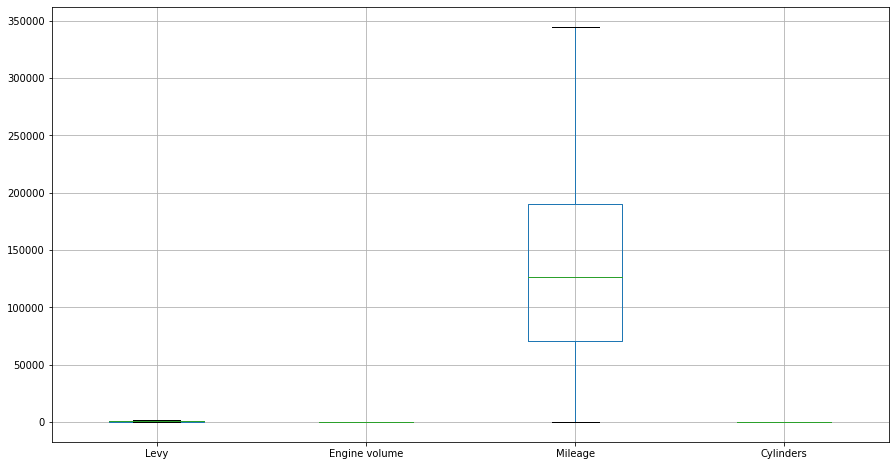

In [38]:
def FindOutliersLim(column_name, df):
    q1 = np.percentile(df[column_name], 25) #1st quartile - 25%
    q3 = np.percentile(df[column_name], 75) #3rd quartile - 75%
    IQR = q3 - q1 #Inter Quartile Range

    liniency_factor = 1.3
    lim = IQR * liniency_factor
    lower_lim, upper_lim = q1 - lim, q3 + lim
    return lower_lim, upper_lim
def RemoveOutlier(df, column_name, upper_lim, lower_lim):
    outlier_list = [x for x in df[column_name] if x < upper_lim] #List of Outliers that exist
    outlier_elimmed = [x for x in df[column_name] if x >= lower_lim and x <= upper_lim]
    final_col = np.where(df[column_name]>upper_lim,upper_lim,np.where(df[column_name]<lower_lim,lower_lim,df[column_name]))
    return final_col
outliers = ['Levy', 'Engine volume', 'Mileage', 'Cylinders']
for i in outliers:
    lower_lim, upper_lim = FindOutliersLim(column_name=i, df=df)
    df[i] = RemoveOutlier(df, i, upper_lim=upper_lim, lower_lim=lower_lim)
df[outliers].boxplot()

In [57]:
mileage_intervals = [i for i in range(0,10)]
df['Mileage_BIN'] = p.cut(df['Mileage'], len(mileage_intervals), labels=mileage_intervals)
df['Mileage_BIN'] - df['Mileage_BIN'].astype(np.float16)
engineVol_intervals = [i for i in range(0,5)]
df['EngineVolume_BIN'] = p.cut(df['Engine volume'], len(engineVol_intervals), labels=engineVol_intervals)
df['EngineVolume_BIN'] = df['EngineVolume_BIN'].astype(float)

TypeError: Object with dtype category cannot perform the numpy op subtract

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27482 entries, 0 to 27481
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Unnamed: 0        27482 non-null  int64   
 1   Levy              27482 non-null  float64 
 2   Manufacturer      27482 non-null  object  
 3   Model             27482 non-null  object  
 4   Prod. year        27482 non-null  int64   
 5   Category          27482 non-null  object  
 6   Leather interior  27482 non-null  object  
 7   Fuel type         27482 non-null  object  
 8   Engine volume     27482 non-null  float64 
 9   Mileage           27482 non-null  float64 
 10  Cylinders         27482 non-null  float64 
 11  Gear box type     27482 non-null  object  
 12  Drive wheels      27482 non-null  object  
 13  Doors             27482 non-null  object  
 14  Wheel             27482 non-null  object  
 15  Color             27482 non-null  object  
 16  Airbags           2748